In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV as RandSearch
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import time
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import math
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
import random
import warnings
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.neighbors import KNeighborsRegressor as KNR
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
f = pd.read_csv('./Oct01_Centralization/Figure_4/Full Au Sheets/Au_Nis.csv')
f = f[(f['P'] == 23) & (f['L'] == 16) & (f['D'] == 8.5)]
f.sort_values(by='FE', ascending=False, inplace=True)
f

,P,L,D,Ep,Ex1,Ex2,Ex3,Ex4,FE,i_total
126697,23.0,16.0,8.5,0.3,-4.49,-2.0,-4.93,-7.0,0.989998,0.578375
126698,23.0,16.0,8.5,0.5,-4.49,-2.0,-4.93,-7.0,0.986479,1.127157
126696,23.0,16.0,8.5,0.1,-4.49,-2.0,-4.93,-7.0,0.977858,-1.025942
126699,23.0,16.0,8.5,0.7,-4.49,-2.0,-4.93,-7.0,0.464298,1.570398


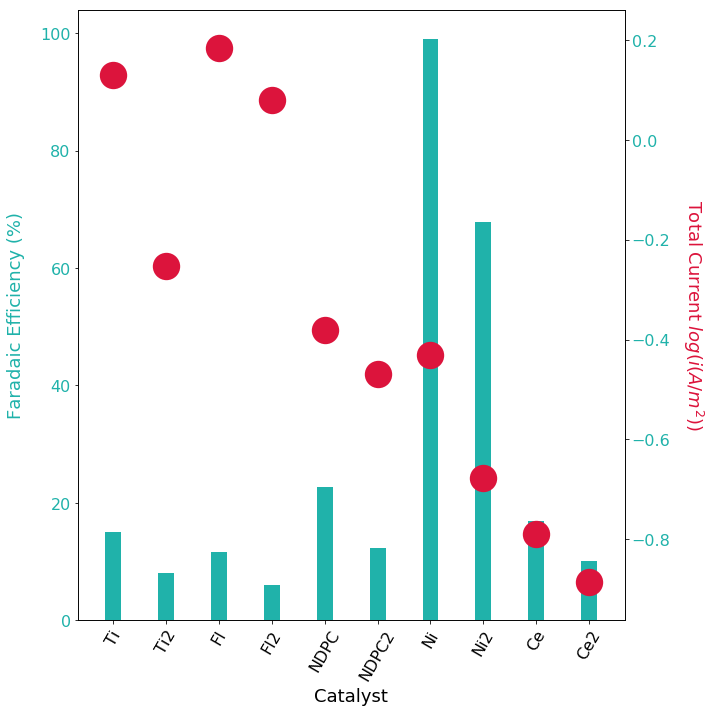

In [16]:
f = pd.read_csv('./Oct01_Centralization/Figure_4/Au_Cat_Comp_toGraph.csv')
labels = ['Ti', 'Ti2', 'Fl', 'Fl2', 'NDPC', 'NDPC2', 'Ni', 'Ni2', 'Ce', 'Ce2']
fig, ax1 = plt.subplots(figsize=(10,10))
color = 'lightseagreen'
ax1.set_xlabel('Catalyst', fontsize=18)
ax1.set_ylabel('Faradaic Efficiency (%)', color=color, fontsize=18, labelpad=15)
ax1.bar(labels, f['FE']*100, color=color, width=0.3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16, rotation=60)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Total Current $log(i(A/m^2))$', color='crimson', fontsize=18, rotation=270, labelpad=35) 
ax2.scatter(labels, f['i_total'], s=500, facecolors='crimson', edgecolors='crimson', linewidths=5)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

fig.tight_layout()
fig.savefig('./Oct01_Centralization/Figure_4/i_total_Max_Au.png', dpi=150)

In [12]:
start_time = time.time()
from sklearn.metrics import make_scorer

MSE_scorer = make_scorer(MSE)
#note: the values look like they are inexact, but they are stored in full. Ex: 0.002 shown may be 0.002123482

#Given a library (keys=model params, values=list of options), finds best parameter combination using grid search
#This can be used with random search as well, continues apply parameters to model and report MSE and calls a fucntion
#To write a file with useful information about model.
#Can be improved by being made more general, right now specifically implemented for AdaBoot Regressor
def paramFind():    
    
    print('ADA BOOST ENTERED')
    ada = AdaBoostRegressor(random_state=31)
    tree = DecisionTreeRegressor(max_depth=20)
    param_grid = {'base_estimator':[tree], 'n_estimators':[1500], 'learning_rate':[0.1]}
    best_params = model_to_train_2(ada, param_grid, x_train, y_train)
    ada = AdaBoostRegressor(**best_params)
    ada.fit(x_train, y_train)
    y_pred = ada.predict(x_test)
    modelEvaluation(y_pred, y_test, 'AD_NRR', 'i_NRR(A/m^2)', ada.feature_importances_)
    print('ADA MSE is:', MSE(y_pred, y_test))
    print('ADABOOST DONE')
    return


#Change the datatypes in a dataframe to match desired value (ex. int to float)
#Could be improved/modified with polymorphic functions  or default parameter values to be changed
def change_dtypes(df, dtype):
    for column in df:
        if df[column].dtypes != dtype:
            df[column] = df[column].astype(dtype)
    return df

#Load all data in filepath with desired extension (csv here), made more specific to use here due to its
#Conversion to absolute values, rounding, renaming columns 
def organize_data(file):
    frame = pd.read_csv(file)
    return frame

#Perform base 10 log transformation on df using indexing of datframe - start inclusive and end exclusive
#Mapping correlates each value with its equvialent post transforamtion --> the lmabda function
def take_logs(frame, start, end):
    for ex_cur in frame.iloc[:,start:end]:
        frame[ex_cur] = frame[ex_cur].map(lambda x: math.log10(x))
    return frame
 
#Train test split based on range of df index values and label    
def split(df, s_range, f_range, label):
    x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,s_range:f_range], (df[label]), test_size=0.3, random_state=31)
    return x_train, x_test, y_train, y_test

In [13]:
''''''
#This is where Im initializing the frame, it has to be done after above methods --> scripting language
#Provide label to use for split and voltage if necessary
frame = organize_data('./SuccinctDataFiles/Full_Original_Data.csv')
alg_frame = frame.copy()
rand_frame = frame.copy()

x_train, x_test, y_train, y_test = split(frame, 0, 8, 'i_total')
print(len(x_train), len(x_test), len(y_train), len(y_test))

x_train_df = pd.DataFrame(data=x_train)
x_test_df = pd.DataFrame(data=x_test)
y_test_df = pd.DataFrame(data=y_test)
y_train_df = pd.DataFrame(data=y_train)
x_test_df = x_test_df.join(y_test_df)
x_train_df = x_train_df.join(y_train_df)
#x_test_df.to_csv('og_testing_data.csv')
x_train_df.to_csv('Oct01_Centralization/Figure_2/Complete_Training_Data.csv', index=False)
    
normalizer = MinMaxScaler()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)
    
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

163296 69984 163296 69984


In [14]:
#Uses grid search to search parameter grid given (combinatorial) as it applies to model, returns the best parameters
#as determined by the scoring method of the grid search
def model_to_train_2(model, param_grid, feature=x_train, labels=y_train):
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=3)
    print('Fitting Model')
    best_model = grid_search.fit(features, labels)
    print(grid_search.grid_scores_)
    print('Best Params: ', best_model.best_params_, best_model.best_score_)
    return best_model.best_params_

def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def percError(a, y_test=y_test):
    a, y_test = np.array(a), np.array(y_test)
    return np.mean(100*np.abs(a - y_test)/y_test)
    
def MSE_helper(b, ytest, mse_one):
    mse_perm = MSE(b, ytest)
    return abs(100*(mse_perm - mse_one)/mse_one)
    
#Used to report info of merit in a text file for saving/reference
def modelEvaluation(a, labelname, feature_imp=None, y_test=y_test):
    plt.figure(figsize=(12,10))
    plt.scatter(y_test, a, alpha=0.1, color='c', marker=',')
    plt.xlabel('Real ' + labelname, size=16)
    plt.ylabel('Predicted ' + labelname ,size=16)
    plt.title((labelname + ' Real vs. Distributed Modelled Data'), size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig(labelname + '.png')
    file = open(labelname + '.txt', 'w')
    file.write("The mean value of the real data is " + str(round(np.mean(y_test), 4)) + '\n')
    file.write("The standard deviation of real data is " + str(round(np.std(y_test), 4)) + '\n')
    file.write("The mean value of the predicted values is " + str(round(np.mean(a), 4)) + '\n')
    file.write("The standard deviation of predicted values is " + str(round(np.std(a), 4)) + '\n')
    file.write("The average percent error is " + str(round(percError(a), 4)) + "%" + '\n')
    file.write("The RMSE is " + str(round(rmse(a, y_test), 4)) + '\n')
    file.write("The MSE is " + str(round(MSE(a, y_test), 8)) + '\n')
    file.write("The MSE as a percent error: " + str(abs(round((100*MSE(a, y_test)/np.mean(y_test)), 8))) + '%' + '\n')
    a = pd.DataFrame(data=a, columns=['pred_val'])
    y_test = pd.DataFrame(data=y_test)
    y_test.reset_index(inplace=True)
    comp = pd.concat([a, y_test], axis='columns')
    comp['er'] = abs((100*comp['pred_val'] - comp[labelname])/comp[labelname])
    comp = comp.sort_values(by=labelname, ascending=True)
    comp10 = comp[comp[labelname] <= comp[labelname].quantile(0.01)]
    comp90 = comp[comp[labelname] >= comp[labelname].quantile(0.9)]
    compLow = comp[(comp[labelname] >= comp[labelname].quantile(0.05)) & (comp[labelname] <= comp[labelname].quantile(0.1))]
    compMid = comp[(comp[labelname] >= comp[labelname].quantile(0.45)) & (comp[labelname] <= comp[labelname].quantile(0.55))]
    file.write("The Bottom 1% Error is " + str(round(percError(comp10['pred_val'], comp10[labelname]), 4)) + "%" + '\n')
    file.write("The Error from 5-10% is " + str(round(percError(compLow['pred_val'], compLow[labelname]), 4)) + "%" + '\n')
    file.write("The Top 10% Error is " + str(round(percError(comp90['pred_val'], comp90[labelname]), 4)) + "%" + '\n')
    file.write("The Mid 10% Error is " + str(round(percError(compMid['pred_val'], compMid[labelname]), 4)) + "%" + '\n')
    if feature_imp is not None:
        feat_imp = zip(list(frame.iloc[:,:8]), feature_imp)
        for feat, imp in feat_imp:
            file.write(feat + " : " + str(round(imp, 8)) + '\n')
    file.close()
    return comp

#Implementation of adaboost algorithm using given parameters, used to return feature importances, the model, and
#the predicted values
def AdaBoost(params, base, feats=x_train, labels=y_train, testfeats=x_test):
    ada = AdaBoostRegressor(base_estimator=base, **params)
    ada.fit(feats, labels)
    y_pred = ada.predict(testfeats)
    return ada, y_pred, ada.feature_importances_

#Initialize model, call model method, save the model, and call evaluation to make text file with relevent info
#such as rmse, mse, feature importances, percent error, stats on real and predicted data
def perform_full_evaluation(labelname, frame=frame):
    base2 = DecisionTreeRegressor(max_depth=8)
    params = {'n_estimators':800, 'learning_rate':0.1, 'random_state':44}
    model, y_pred, feature_importances = AdaBoost(params, base2)
    pickle.dump(model, open(labelname + '.sav', 'wb'))
    comp = modelEvaluation(y_pred, labelname, feature_importances)
    return comp

#Used to determine if random state used when model is initialized is strongly influencing model predictions
def evaluate_random_state(potential, random_value, filename):
    base2 = DecisionTreeRegressor(max_depth=20)
    params = {'n_estimators':1500, 'learning_rate':0.1, 'random_state':random_value}
    _, _, feature_importances = AdaBoost(params, base2)
    feature_importances = zip(list(frame.iloc[:,0:3]), feature_importances)
    file = filename
    file.write('Potential: ' + str(potential) + '\n')
    file.write('Random State' + ' : ' + str(random_value) + '\n')
    for feat, imp in feature_importances:
        file.write(feat + " : " + str(round(imp, 6)) + '\n')
    return

#Evaluate the importance of a feature on model prediction by comparing a model trained on un-modified data and a model
#trained on data with one feature (at a time) permuted. Value of merit (%error, mse etc.) under consideration.
def permute_feature_test(label, model, features, frame=frame):
    frame_copy = frame
    _, xtest, _, ytest = split(frame_copy, 0, 8, label)
    normalizer = MinMaxScaler()
    scaler = StandardScaler()
    xtest = normalizer.fit_transform(xtest)
    xtest = scaler.fit_transform(xtest)
    xtest = pd.DataFrame(data=xtest, columns=list(frame.iloc[:,:8].columns.values))
    to_permute = features
    for feature in to_permute:
        file = open(('Perm_of_' + feature + '.txt'), 'w')
        file.write('Permutation of ' + feature + '\n')
        a = model.predict(xtest)
        old_error = MSE(a, ytest)
        xtest_copy = xtest.copy()
        case = np.array([])
        for _ in list(range(5)):
            b, new_error = permute_helper(xtest_copy, feature, model, ytest, old_error)
            print(str(round(old_error, 5)) + " " + str(round(new_error, 5)) + "\n")
            dError = abs(100*(old_error-new_error)/old_error)
            file.write('∆PercentMSEError = ' + str(dError) + '%\n')
            case = np.append(case, dError)
        file.write('Avg ∆PercentMSEError = ' + str(case.mean()) + '\n' + 'Std Dev = ' + str(case.std()))
        file.close()
        plt.scatter(b, y_test, marker='*', c='m')
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.title(feature + " Real vs. Modelled Data")
        plt.savefig(feature + '.png')
    return

def permute_feature_train(og_model, model2, label, features):
    a = og_model.predict(x_test)
    old_mse = MSE(a, y_test)
    for feat in features:
        file = open(('Perm_of_' + feat + '.txt'), 'w')
        file.write('Permutation of ' + feat + '\n')
        file.write('Old MSE: ' + str(round(old_mse, 8)) + '\n')
        case = np.array([])
        shuffle_x = x_train.copy()
        shuffle_x = pd.DataFrame(data=shuffle_x, columns=list(frame.iloc[:,0:8].columns.values))
        for _ in list(range(1)):
            #shuffle_x[feat] = np.random.permutation(shuffle_x[feat])
            m = shuffle_x[feat].min()
            M = shuffle_x[feat].max()
            lst = []
            [lst.append(random.uniform(m,M)) for _ in range(len(shuffle_x))]
            shuffle_x[feat] = lst
            model2.fit(shuffle_x, y_train)
            b = model2.predict(x_test)
            new_mse = MSE(b, y_test)
            file.write('New MSE: ' + str(round(new_mse, 8)) + '\n')
            case = np.append(case, new_mse)
        file.write('Avg New MSE = ' + str(case.mean()) + '\n')
        file.write('∆MSE (new-old) = ' + str(case.mean() - old_mse) + '\n')
        file.write('%∆MSE = ' + str(100*(case.mean() - old_mse)/old_mse) + '\n')
        file.write('∆PercentError = ' + str(percError(b) - percError(a)) + '\n')
        file.close()
        plt.scatter(b, y_test, marker='*', c='m', alpha=0.1)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.title(feat + " Real vs. Permuted_Modelled Data")
        #plt.savefig(feat + '.png')
    
#Helper function to return percent error of permuted model
def permute_helper(values, feature, model, ytest, old_error):
    values[feature] = np.random.permutation(values[feature])
    b = model.predict(values)
    print(str(values.iloc[:5,:7]))
    return b, (MSE_helper(b, ytest, old_error))

In [5]:
#





#Here Ends the General Stuff to Initialize, Below Are Blocks with Specific Purposes





#

In [6]:
#tools to make a list of values surrounding a feature as a stepping stone optimization of morphology
#e.g. L=15 --> make a list of values from 7.5-->22.5 with given incrementation
#at the bottom, frame is separated out based on given Ex values provided

def float_range(start, finish, dx):
    lst = [start]
    while(start < finish):
        start = round((start + dx), 2)
        lst.append(start)
    return lst

def make_list(lst, x, dx): #will add feat to use, val from sep fcn
    i = lst.index(x)
    if(i != 0 and i != len(lst)-1): #it is not the first or last member of list, relevant to list generation
        start = x - ((lst[i] - lst[i-1])/2)
        end = x + ((lst[i+1] - lst[i])/2)
        return float_range(start, end, dx)
    elif(i == 0):
        lim = (lst[i+1] - lst[i])/2
        return float_range(x-lim, x+lim, dx)
    else:
        lim = (lst[i] - lst[i-1])/2
        return float_range(x-lim, x+lim, dx)

df = frame.copy(deep=True)
df = df.loc[(df['Ep'] == 0.3) & (df['Ex1'] == -3) & (df['Ex2'] == -7) & (df['Ex3'] == -2) & (df['Ex4'] == -6)]
df = df.sort_values(by='FE', ascending=False)
df.reset_index(inplace=True)
df = df.drop(['index'], axis='columns')
frame.describe()

,P,L,D,Ep,Ex1,Ex2,Ex3,Ex4,FE,i_total,FE_Model,i_total_Model
count,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000
mean,18.333333,31.666667,3.100000,0.400000,-4.500000,-4.500000,-4.500000,-4.500000,0.660351,0.462137,0.659637,0.474696
std,8.498384,14.337240,2.727642,0.223607,1.707829,1.707829,1.707829,1.707829,0.390470,1.533793,0.390352,1.529293
min,10.000000,15.000000,0.500000,0.100000,-7.000000,-7.000000,-7.000000,-7.000000,0.001872,-3.862421,-0.094294,-3.898332
25%,10.000000,15.000000,1.000000,0.250000,-6.000000,-6.000000,-6.000000,-6.000000,0.173047,-0.421054,0.181633,-0.411051
50%,15.000000,30.000000,2.000000,0.400000,-4.500000,-4.500000,-4.500000,-4.500000,0.913771,1.021422,0.908700,1.028535
75%,30.000000,50.000000,4.000000,0.550000,-3.000000,-3.000000,-3.000000,-3.000000,0.995248,1.367473,0.991113,1.384500
max,30.000000,50.000000,8.000000,0.700000,-2.000000,-2.000000,-2.000000,-2.000000,1.000000,2.557998,1.087232,2.617672


In [7]:
#Find the max value for a given label given a set of exchange current densities
#Create list of values surrounding that value, predict label based on new morphology
#Select the row with the maximum label
#Pull the values to perturb out
#Pull the Ex values out
#Make lists around P,L,D,E, take each combination, find max predicted label

feats = list(df.columns.values)[0:3]
vals = df[(df['FE'] == df['FE'].max())].iloc[:,:3]
values = []
for val in vals.iloc[0]:
    values.append(val)
    
exs = df[(df['FE'] == df['FE'].max())].iloc[:,4:8]
exchanges = []
for ex in exs.iloc[0]:
    exchanges.append(ex)
    
list_of_lists = []
for feat, val in zip(feats, values):
    if(feat != 'D'):
        lst = df[feat].unique()
        lst.sort()
        list_of_lists.append(make_list(list(lst), val, 0.5))
    else:
        lst = df[feat].unique()
        lst.sort()
        list_of_lists.append(make_list(list(lst), val, 0.1))
frame.describe()

,P,L,D,Ep,Ex1,Ex2,Ex3,Ex4,FE,i_total,FE_Model,i_total_Model
count,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000,233280.000000
mean,18.333333,31.666667,3.100000,0.400000,-4.500000,-4.500000,-4.500000,-4.500000,0.660351,0.462137,0.659637,0.474696
std,8.498384,14.337240,2.727642,0.223607,1.707829,1.707829,1.707829,1.707829,0.390470,1.533793,0.390352,1.529293
min,10.000000,15.000000,0.500000,0.100000,-7.000000,-7.000000,-7.000000,-7.000000,0.001872,-3.862421,-0.094294,-3.898332
25%,10.000000,15.000000,1.000000,0.250000,-6.000000,-6.000000,-6.000000,-6.000000,0.173047,-0.421054,0.181633,-0.411051
50%,15.000000,30.000000,2.000000,0.400000,-4.500000,-4.500000,-4.500000,-4.500000,0.913771,1.021422,0.908700,1.028535
75%,30.000000,50.000000,4.000000,0.550000,-3.000000,-3.000000,-3.000000,-3.000000,0.995248,1.367473,0.991113,1.384500
max,30.000000,50.000000,8.000000,0.700000,-2.000000,-2.000000,-2.000000,-2.000000,1.000000,2.557998,1.087232,2.617672


In [111]:
#### start_time = time.time()
i_mlp = pickle.load(open('./Sep03_itotal/mlp_sep02_i_total.sav', 'rb'))
fe_mlp = pickle.load(open('./Aug11_MLPRegressor/mlp_relu_aug11.sav', 'rb'))
#fe_mlp = model2
def fix(ar):
    ar = ar.reshape(1,-1)
    ar = normalizer.transform(ar)
    ar = scaler.transform(ar)
    return ar


#df_pred = pd.DataFrame(data="", columns=['P','L','D','Ep','Ex1','Ex2', 'Ex3','Ex4','FE'])
df_pred = pd.DataFrame()
columns = ['P','L','D','Ep','Ex1','Ex2','Ex3','Ex4', 'FE','i_total']

list_of_lists[0] = float_range(-7,-2, 0.1)
#list_of_lists[1] = float_range(3,80,1)
#list_of_lists[2] = [0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
#list_of_lists.append(float_range(0.1, 0.7, 0.2))
#list_of_lists.append(float_range(-5,-3,1))


#9.39E-07	-2.04E+05	1.46E-03	4.23E-06
#6.92E-06	-1.18E+06	1.95E-02	5.67E-05
#4.41E-06	4.84E+06	7.89E-03	2.23E-05


for p in list_of_lists[0]:
    #for l in list_of_lists[1]:
        #for d in list_of_lists[2]:
            #for e in [0.1,0.3,0.5,0.7]:
                #if(d >= p): continue
                cur = np.array([10, 30, 2, 0.3, -2, -6, -2, p])
                fe_val = fe_mlp.predict(fix(cur))
                i_val = i_mlp.predict(fix(cur))
                cur = np.append(cur, fe_val)
                cur = np.append(cur, i_val)
                df_pred = df_pred.append(dict(zip(columns, cur)), ignore_index=True)


#future: for each combination, predict the FE and add a new dict element-->key = morphology, value = FE
#Sort by the FE, report the top five and also report the i_total for those 5
print("--- %s seconds ---" % ((time.time() - start_time)/60))
df_pred = df_pred[['P','L','D', 'Ep', 'Ex1', 'Ex2', 'Ex3', 'Ex4', 'FE', 'i_total']]

--- 71.85161658128102 seconds ---


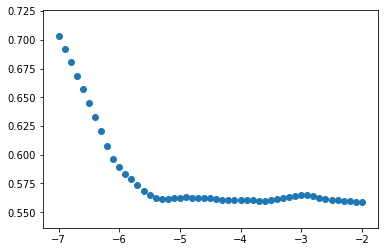

In [112]:
df_pred
plt.scatter(df_pred['Ex4'], df_pred['FE'])

In [113]:
#lst = []
#for i, row in df_pred.iterrows():
#    if(row['P'] == 10 or row['P'] == 15 or row['P'] == 30):
#        lst.append('Old')
#    else:
#        lst.append(None)
#df_pred['State'] = lst
df_pred.to_csv('./Oct01_Centralization/Figure_4/excurs/Ex4_NN.csv', index=False)

In [ ]:
#Figure Development Block --> Prediction
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score as r2
from math import sqrt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

def standard_plot(a, label, y_test=y_test, fontsize=18, alpha=0.1):
    a = a-1
    y_test = y_test-1
    low = a.min() if a.min() < y_test.min() else y_test.min()
    high = a.max() if a.max() > y_test.max() else y_test.max()
    low = low+low*0.1
    high = high+high*0.1
    mse = MSE(a, y_test)
    fig, ax1 = plt.subplots(figsize=(14,14))
    ax = sns.scatterplot(y_test, a, color='lightseagreen', alpha=0.2, ax=ax1)
    #anchored_text = AnchoredText('RMSE = ' + str(round(sqrt(mse),3)) + '\nR$^2$ = ' + str(round(r2(a, y_test), 3)),
    #                         prop={'fontsize':fontsize}, loc=4)
    #ax.add_artist(anchored_text)
    ax.set_xlabel('Comsol ' + label + ' log($i(mA/cm^2)$)', fontsize=fontsize)
    ax.set_ylabel('Nerual Network ' + label + ' log($i(mA/cm^2)$)', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    ax.set_xlim(low,high)
    ax.set_ylim(low,high)
    #ax.plot([low,high],[low,high], color='k', linestyle='--', label='Ideal Line')
    #ax.legend(fontsize=fontsize)
    fig.tight_layout()
    fig.savefig('./Sep30_FigUpdate/Figure_2/' + label + '.png')

model = pickle.load(open('./Sep03_itotal/mlp_sep02_i_total.sav', 'rb'))
a = model.predict(x_test)
standard_plot(a, 'Total Current')

#' log($i(A/m^2)$)'
#Sep03_itotal/mlp_sep02_i_total.sav
#./Aug11_MLPRegressor/mlp_relu_aug11.sav

In [ ]:
#Figure 3 - Single Feature Morphology Dependence Graphing

df = pd.read_csv('Oct01_Centralization/Figure_3/Periodicity/L30D2.csv')
df_old = df[(df['State'] == 'Old')]
df_new = df[(df['State'] != 'Old')]

fig, ax1 = plt.subplots(figsize=(10,10))

color = 'lightseagreen'
ax1.set_xlabel('Periodicity', fontsize=18)
ax1.set_ylabel('Faradaic Efficiency (%)', color=color, fontsize=18, labelpad=15)
ax1.scatter(df_new['P'], df_new['FE']*100, facecolors='none',edgecolors='lightseagreen',label='Model',s=500, linewidths=3)
ax1.scatter(df_old['P'], df_old['FE']*100, label=None,  s=500, facecolors='none', edgecolors='crimson', linewidths=3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'crimson'
ax2.set_ylabel('Total Current $log(i(A/m^2))$', color=color, fontsize=18, rotation=270, labelpad=35) 
ax2.scatter(df_new['P'], df_new['i_total']-1, color='lightseagreen', label='Model',  s=600)
ax2.scatter(df_old['P'], df_old['i_total']-1, color='crimson', label=None,  s=600)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

fig.tight_layout()
fig.savefig('./Oct01_Centralization/Figure_3/Periodicity/L30D2.png', dpi=600)

In [ ]:
#Figure 3 plots

df = pd.read_csv('./Oct01_Centralization/InitBounds_55235_Labelled.csv')
df_old = df[df['State'] == 'Old']
df_new = df[df['State'] != 'Old']

plt.figure(figsize=(10,10))
plt.scatter(df_new['FE'], df_new['FE_Model'], color='lightseagreen', alpha=0.3, s=110)
plt.scatter(df_old['FE'], df_old['FE_Model'], color='crimson', alpha=0.7, s=160)


plt.tight_layout()
plt.savefig('./Oct01_Centralization/Figure_3/FE_55235.png', dpi=600)

In [ ]:
# time comparison slots

x = [1,2,3,4,5,6]
#y1 = [0.0175, 0.145, 1.23, 12.6, 344, 3440]
y1 = [-1.76, -0.84, 0.090, 1.10, 2.54, 3.54]
#y2 = [25, 436, 3003, 30030, 300300, 3003000]
y2 = [1.40, 2.64, 3.48, 4.48, 5.48, 6.48]
#y1 = [math.log10(y) for y in y1]
#y2 = [math.log10(y) for y in y2]

print(y1, y2)

plt.figure(figsize=(10,10))

plt.plot([1,2,3,4,5], [-1.76,-0.84,0.09,1.10,2.54], color='lightseagreen', label='Neural Network', linewidth=5)
plt.plot([5,6], [2.54, 3.54], color='lightseagreen', linestyle=':', label='Neural Network Extrapolated', linewidth=5)
plt.scatter(x, y1, color='lightseagreen', s=200)


plt.plot([1,2,3], [1.4,2.64,3.48], color='crimson', label='Comsol', linewidth=5)
plt.plot([3,4,5,6], [3.48,4.48,5.48,6.48], color='crimson', linestyle=':', label='Comsol Extrapolated', linewidth=5)
plt.scatter(x, y2, color='crimson', s=200)


plt.xlabel('Morphologies Predicted (log(n))', fontsize=18, labelpad=20)
plt.ylabel('Time (s)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('./Oct01_Centralization/Figure_4/Time_to_Predict.png')

In [ ]:
#Calling Permute Train
model2 = MLP(early_stopping=True, validation_fraction=0.3, learning_rate_init=1e-3,
                         hidden_layer_sizes=2000, activation='relu', verbose=True, random_state=10)
permute_feature_train(pickle.load(open('./Sep03_itotal/mlp_sep02_i_total.sav', 'rb')), model2,
                      'i_total', ['P','L','D','Ep','Ex1','Ex2','Ex3','Ex4'])

In [ ]:
#Plotting Horizontal Bar Graph

import matplotlib.patches as mpatches

#I separated the feats and made numbered keys to control the order in which they are plotted
morph_mse = {0:422.1, 1:191.5, 2:343.7, 3:1922.60, 
            4:1050.20, 5:160.82, 6:4040.26, 7:259.62}

feats = ['$Periodicity$ $(µm)$', '$Length$ $(µm)$', '$Diameter$ $(µm)$',
         '$E_{applied}$ $(V)$', '$i_{1,0,NRR}$ $(A/m^2)$', '$i_{2,0,NRR}$ $(A/m^2)$',
         '$i_{1,0,HER}$ $(A/m^2)$', '$i_{2,0,HER}$ $(A/m^2)$']

plt.figure(figsize=(20,9))
plt.barh(range(len(morph_mse)), list(morph_mse.values()), color=['lightseagreen',
                                                                 'lightseagreen',
                                                                 'lightseagreen',
                                                                 'crimson',
                                                                 'crimson',
                                                                 'crimson',
                                                                 'crimson',
                                                                 'crimson'])
plt.yticks(range(len(morph_mse)), labels=feats, fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('%∆MSE', fontsize=18, labelpad=20)
plt.ylabel('Input Vector', fontsize=18)
red_patch = mpatches.Patch(color='lightseagreen', label='Unscaled')
blue_patch = mpatches.Patch(color='crimson', label='Scaled')
plt.legend(handles=[red_patch, blue_patch], fontsize=18)
plt.tight_layout()
plt.savefig('./Oct01_Centralization/Figure_3/Feat_Importances.png')
#print(feat_mse.keys())

In [ ]:
#Cross validation of models, MSE as metric, concerned about early-stopping
mlp = pickle.load(open('./Aug11_MLPRegressor/mlp_relu_aug11.sav', 'rb'))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(mlp, x_train, y_train, scoring="neg_mean_squared_error", cv=10)


mlp_scores = -scores

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(mlp_scores)

In [ ]:
#also 2 y-axis graphing

x = list(range(len(dfg)))

data1 = dfg['FE']*100
data2 = dfg['i_total']

fig, ax1 = plt.subplots(figsize=(14,14))

color = 'lightseagreen'
ax1.set_xlabel('Morphology', fontsize=18)
ax1.set_ylabel('Faradaic Efficiency (%)', color=color, fontsize=18, labelpad=15)
ax1.scatter(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'crimson'
ax2.set_ylabel('Total Current $log(i(A/m^2))$', color=color, fontsize=18, rotation=270, labelpad=35) 
ax2.scatter(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.savefig('./Sep18_Figures/figure_4/FE_90_i_total_20A_m^2.png')

In [ ]:
#gold doubly y axis graph  - fig 4
df = pd.read_csv('./Oct01_Centralization/Figure_4/FE_Max_Au.csv')
df_2 = pd.read_csv('./Oct01_Centralization/Figure_4/i_total_Max_Au.csv')

labels = ['Ce', 'Ti', 'Ni', 'Fl', 'NDPCs']

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,10))
color = 'lightseagreen'
ax1.set_xlabel('Catalyst', fontsize=18)
ax1.set_ylabel('Faradaic Efficiency (%)', color=color, fontsize=18, labelpad=15)
ax1.bar(labels, df_2['FE']*100, color=color, width=0.3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=16)
ax1.tick_params(axis='x', labelsize=16, rotation=60)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Total Current $log(i(A/m^2))$', color='crimson', fontsize=18, rotation=270, labelpad=35) 
ax2.scatter(labels, df_2['i_total']-1, s=500, facecolors='crimson', edgecolors='crimson', linewidths=5)
ax2.tick_params(axis='y', labelcolor=color, labelsize=16)

fig.tight_layout()
fig.savefig('./Oct01_Centralization/Figure_4/i_total_Max_Au.png', dpi=600)

In [ ]:
#merging guidance for merging comsol data with split model FE and Current data
#allows centralization of data for a certain EX range like 55235

comsol_55235 = pd.read_csv('./Aug29_Comsol_Data/55235/CE5_5235.csv')
comsol_55235 = comsol_55235.drop(['HER', 'NRR'], axis=1)
comsol_55235.describe()

model_fe = pd.read_csv('./Aug16_toComp_CSVs/Range_E05_5235.csv')
model_fe = model_fe.drop(['Unnamed: 0', 'Ep', 'Ex1', 'Ex2', 'Ex3', 'Ex4'], axis=1)
model_i = pd.read_csv('./Sep03_itotal/Range_E05_5235.csv')
model_i = model_i.drop(['Unnamed: 0', 'Ep','Ex1', 'Ex2', 'Ex3', 'Ex4'], axis=1)
model_fe.describe()


model_fe = model_fe.merge(model_i, left_on=['P','L','D'], right_on=['P','L','D'])

model_fe = model_fe.rename({'FE':'FE_Model', 'i_total':'i_total_Model'}, axis=1)
model_fe = model_fe.merge(comsol_55235, left_on=['P','L','D'], right_on=['P','L','D'])
model_fe = model_fe[['P','L','D','FE', 'i_total', 'FE_Model', 'i_total_Model']]
model_fe

model_fe.to_csv('Full_55235_Data.csv', index=False)

In [ ]:
#merge existing data with comsol data and label new morphologies vs. unseen morphologies

df_new = pd.read_csv('./Oct01_Centralization/Full_55235_Data_noOG.csv')
df_old = pd.read_csv('./Oct01_Centralization/Full_Original_Data.csv')
df_old = df_old[(df_old['Ep'] == 0.5) & (df_old['Ex1'] == -5) &
                (df_old['Ex2'] == -2) & (df_old['Ex3'] == -3) & (df_old['Ex4'] == -5)]
df_old = df_old.drop(['Ep','Ex1','Ex2','Ex3','Ex4'], axis=1)
df_old['State'] = 'Old'
combo_df = pd.concat([df_new, df_old], axis=0)
combo_df = combo_df.sort_values(by=['P','L','D','State'])
combo_df = combo_df[['P','L','D','FE','i_total','FE_Model','i_total_Model','State']]
combo_df = combo_df.drop_duplicates(['P','L','D'], keep='first')
combo_df.to_csv('./Oct01_Centralization/Final_55235_Labelled.csv')

In [ ]:
#how to add a column with frame-based-value to dataframe
lst = []
for i, row in df.iterrows():
    if(row['L'] == 15 or row['L'] == 30 or row['L'] == 50):
        lst.append('Old')
    else:
        lst.append(None)

In [ ]:
#Do stuff with every value in a file

import os
df = pd.DataFrame()

direc = './Oct01_Centralization/Figure_4/'
good_filenames = [name for name in os.listdir(direc) if name.startswith("Au")]

lst = []

for file in good_filenames:
    cur_df = pd.read_csv(direc + file)
    cur_df.sort_values(by='i_total', ascending=False, inplace=True)
    df = df.append(cur_df.iloc[:1,:])
    lst.append(file)
    
df['Cat'] = lst
#df_pred = df_pred.append(dict(zip(columns, cur)), ignore_index=True)

In [ ]:
feats = {'P':[10,30,0.5], 'L':[15,50, 0.875], 'D':[0.5,8,0.175],
         'Ep':[0.1,0.7,0.015], 'Ex1':[-7,-2,0.125], 'Ex2':[-7,-2,0.125],
         'Ex3':[-7,-2,0.125], 'Ex4':[-7,-2,0.125]}

In [12]:
import random
x_train_df
m = x_train_df['Ep'].min()
M = x_train_df['Ep'].max()
lst = []
[lst.append(random.uniform(m,M)) for _ in range(len(x_train_df))]
x_train_df['Ep'] = lst
x_train_df.head()

,P,L,D,Ep,Ex1,Ex2,Ex3,Ex4,FE
72238,30.0,15.0,4.0,0.489097,-4.0,-2.0,-3.0,-4.0,0.925822
163175,10.0,30.0,4.0,0.455296,-3.0,-6.0,-4.0,-6.0,0.650623
32783,10.0,15.0,2.0,0.604430,-7.0,-5.0,-3.0,-3.0,0.020533
161151,15.0,30.0,2.0,0.660470,-3.0,-5.0,-4.0,-4.0,0.994351
103430,30.0,15.0,4.0,0.521786,-7.0,-2.0,-2.0,-6.0,0.030218
